In [1]:
!pip install tensorflow kagglehub

In [2]:
import time
start_time = time.time()  # เริ่มจับเวลา

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kagglehub
import os
from concurrent.futures import ThreadPoolExecutor

# Download dataset
dataset_path = kagglehub.dataset_download('raman77768/movie-classifier')

# Load CSV
csv_path = f'{dataset_path}/Multi_Label_dataset/train.csv'
df = pd.read_csv(csv_path)
df = df.head(1000)
df['Id'] = df['Id'] + '.jpg'

# Multi-threaded image loading function
def load_image(image_id, directory, target_size=(200, 200)):
    """Load and preprocess a single image."""
    try:
        img_path = os.path.join(directory, image_id)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Rescale
        return img_array
    except Exception as e:
        print(f"Error loading image {image_id}: {e}")
        return None

def threaded_image_loader(image_ids, directory, target_size=(200, 200), num_threads=8):
    """Load images in parallel using ThreadPoolExecutor."""
    images = []
    valid_indices = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(load_image, image_id, directory, target_size)
            for image_id in image_ids
        ]
        for idx, future in enumerate(tqdm(futures, desc="Loading images")):
            result = future.result()
            if result is not None:
                images.append(result)
                valid_indices.append(idx)
    return np.array(images), valid_indices

# Load images in parallel
print("Loading images with multi-threading...")
image_directory = f'{dataset_path}/Multi_Label_dataset/Images'
image_ids = df['Id'].values
images, valid_indices = threaded_image_loader(image_ids, image_directory, num_threads=8)

# Filter dataframe and labels to match successfully loaded images
df = df.iloc[valid_indices].reset_index(drop=True)
labels = df.iloc[:, 2:].values  # Columns 2 onward are labels

# Split into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.1, random_state=42
)

# Create model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(25, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model created and compiled")

end_time = time.time()  # สิ้นสุดการจับเวลา
execution_time = end_time - start_time
print(f"Total execution time: {int(execution_time // 60)} min {execution_time % 60:.2f} sec")

100%|██████████| 248M/248M [00:02<00:00, 116MB/s]

Extracting files...


Loading images with multi-threading...


Loading images: 100%|██████████| 1000/1000 [00:01<00:00, 892.54it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created and compiled
Total execution time: 0 min 25.88 sec


Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/step - accuracy: 0.0504 - loss: 0.9130 - val_accuracy: 0.0100 - val_loss: 0.9889
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0815 - loss: 0.7579 - val_accuracy: 0.0000e+00 - val_loss: 2.3772
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1231 - loss: 0.6812 - val_accuracy: 0.0400 - val_loss: 2.0185
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1616 - loss: 0.6043 - val_accuracy: 0.0600 - val_loss: 2.1254
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1945 - loss: 0.5358 - val_accuracy: 0.2000 - val_loss: 0.7098
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2307 - loss: 0.4536 - val_accuracy: 0.1700 - val_loss: 0.7797
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3012 - loss: 0.3660 - val_accuracy: 0.1000 - val_loss: 0.8703
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3359 - loss: 0.3081 - val_accuracy: 0.27

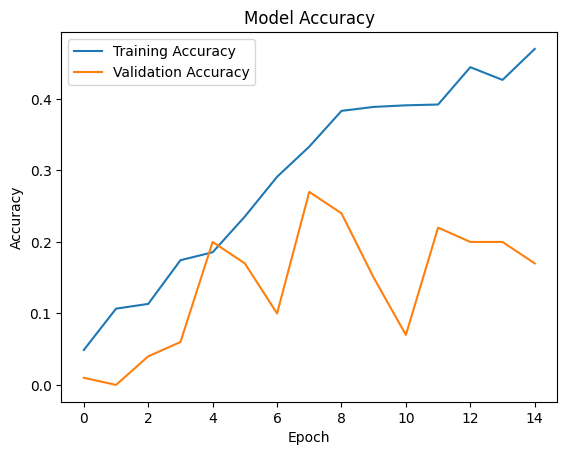

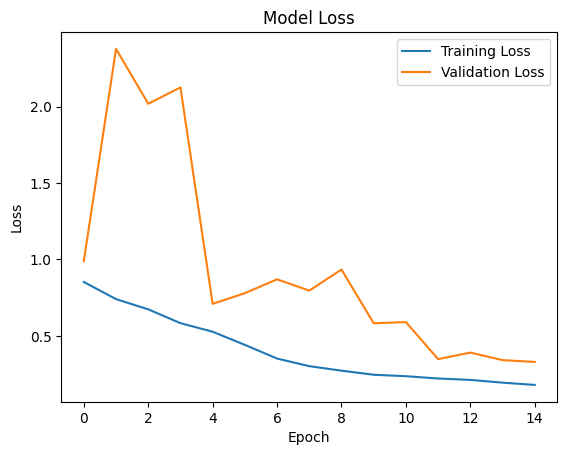

In [3]:
# Create tf.data.Dataset for training and validation
def create_tf_dataset(images, labels, batch_size=32):
    """Create a tf.data.Dataset with prefetching for efficient data loading."""
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels, batch_size=32)
val_dataset = create_tf_dataset(val_images, val_labels, batch_size=32)

# Train model
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
start = time.time()
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[time_callback]
)
end = time.time()
print(f"Total Using Time: {int((end - start) // 60)} min {(end - start) % 60:.2f} sec")
for i, t in enumerate(time_callback.times, 1):
    print(f"Epoch {i}: {t:.2f} sec")

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Multi-threaded prediction function for multiple images
def predict_genre(image_id, directory, model, target_size=(200, 200)):
    """Load and predict genres for a single image."""
    try:
        img_path = os.path.join(directory, image_id)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predictions = model.predict(img_array, verbose=0)[0]
        return image_id, predictions
    except Exception as e:
        print(f"Error predicting for {image_id}: {e}")
        return image_id, None

def threaded_predict(image_ids, directory, model, genre_columns, num_threads=4):
    """Predict genres for multiple images in parallel."""
    predictions_dict = {}
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(predict_genre, image_id, directory, model)
            for image_id in image_ids
        ]
        for future in futures:
            image_id, predictions = future.result()
            if predictions is not None:
                predicted_genres = [(genre, prob) for genre, prob in zip(genre_columns, predictions)]
                predicted_genres = sorted(predicted_genres, key=lambda x: x[1], reverse=True)[:3]
                predictions_dict[image_id] = predicted_genres
    return predictions_dict


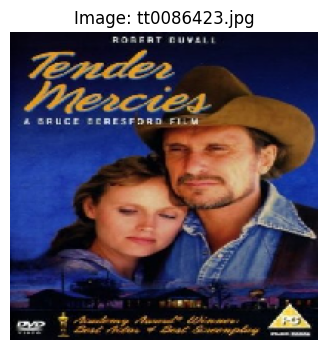


Top 3 genres for tt0086423.jpg:
- Drama (Probability: 0.346)
- Adventure (Probability: 0.284)
- Fantasy (Probability: 0.133)


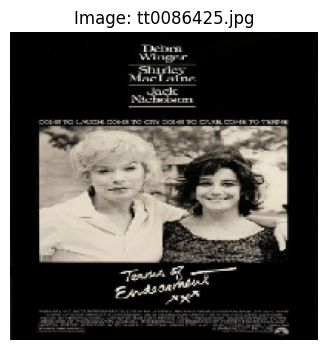


Top 3 genres for tt0086425.jpg:
- Comedy (Probability: 0.340)
- Adventure (Probability: 0.317)
- Drama (Probability: 0.282)


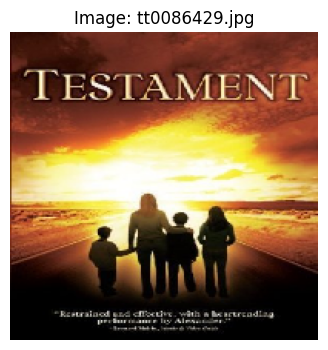


Top 3 genres for tt0086429.jpg:
- Drama (Probability: 0.621)
- Adventure (Probability: 0.156)
- Comedy (Probability: 0.135)


In [13]:
genre_columns = df.columns[2:].tolist()

# Sample image IDs (remove duplicates)
sample_image_ids = ['tt0086423.jpg', 'tt0086425.jpg', 'tt0086429.jpg']  # Add more image IDs
# Make predictions
predictions_dict = threaded_predict(sample_image_ids, image_directory, model, genre_columns, num_threads=4)
# Display predictions, true genres, and images
for image_id in sample_image_ids:
    # Check if image exists
    image_path = os.path.join(image_directory, image_id)
    if not os.path.exists(image_path):
        print(f"\nImage {image_id} not found in {image_directory}")
        continue

    # Display image
    img = load_img(image_path, target_size=(200, 200))
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Image: {image_id}")
    plt.axis('off')
    plt.show()

    # Display predicted genres
    if image_id in predictions_dict:
        print(f"\nTop 3 genres for {image_id}:")
        for genre, prob in predictions_dict[image_id]:
            print(f"- {genre} (Probability: {prob:.3f})")
    else:
        print(f"\nNo predictions for {image_id} (possible error during prediction)")




In [ ]:

image_id = 'tt0086423.jpg'

print(f"Checking image: {image_id}")
print(f"First ID in DataFrame: {df['Id'].iloc[0]}")
if image_id in df['Id'].values:
    true_genres = df[df['Id'] == image_id].iloc[0, 2:]
    true_genres = true_genres[true_genres == 1].index.tolist()
    print("\nTrue Genres from CSV:")
    if true_genres:
        for i, genre in enumerate(true_genres, 1):
            print(f"{i}. {genre}")
    else:
        print("No genres listed in CSV")
else:
    print(f"\nImage {image_id} not found in DataFrame")